In [1]:
import math
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# import cv2
plt.rcParams['image.cmap'] = 'gray'

import funtions from scripts

In [2]:
import os
os.chdir('saliency_model/')

In [3]:
from utils import *

Load the images

In [4]:
img = mpimg.imread('../imgs/balloons.png')
# img2 = cv2.imread('../imgs/balloons.png')

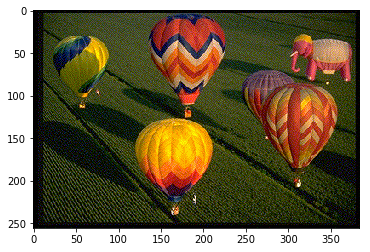

In [5]:
plt.imshow(img);

convert to double if image is uint8

In [6]:
rf = receptiveFieldMatrix(lambda x, y: mexicanHat(x, y, 2, 3))

In [7]:
img_hat = signal.convolve(img[:,:,0], rf, mode='same')

sum together maps across channels

In [8]:
img.shape

(256, 384, 3)

In [9]:
img[:, :, 0].shape

(256, 384)

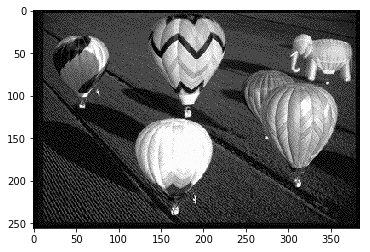

In [10]:
plt.imshow(img[:,:,0]);

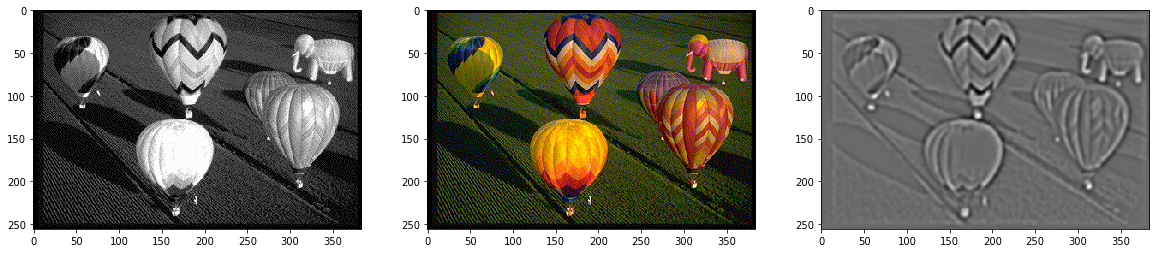

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img[:,:,0])
ax[1].imshow(img)
ax[2].imshow(img_hat);

---

## Determine the size and the number of center scales:  
First we scale the image to different sizes, so it has different resolutions we can work with.

In [12]:
mapwidth = 64
mapheight = round(img.shape[0] * (mapwidth / img.shape[1]))
scalars = [1, 2, 3]

img_list = downsample_image(img, mapheight, mapwidth, scalars)

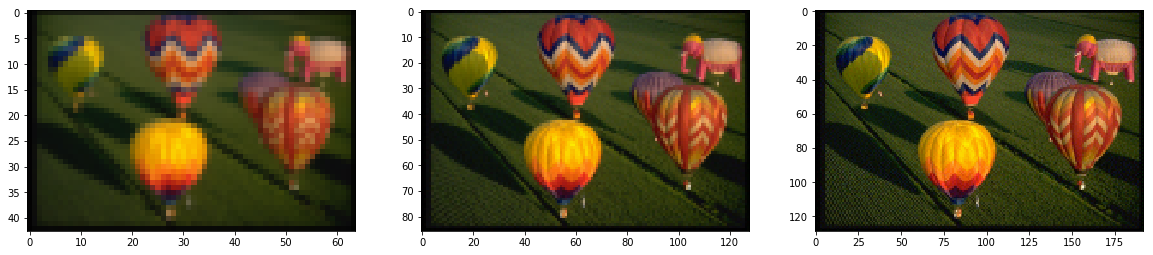

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_list[0])
ax[1].imshow(img_list[1])
ax[2].imshow(img_list[2]);

---

## split to channels & compute salience in each

### Compute intensity

In [14]:
from skimage.morphology import disk
from skimage.filters.rank import mean

In [15]:
img_avg = mean(img_hat, disk(5));

/home/ateska/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


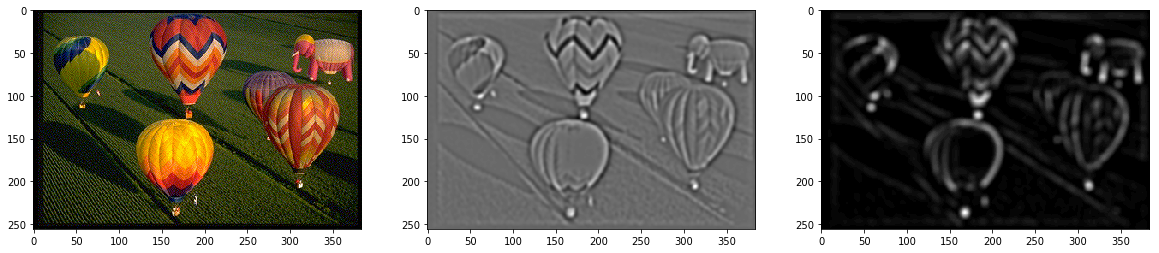

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img)
ax[1].imshow(img_hat);
ax[2].imshow(img_avg);

### Compute color channels

In [17]:
r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

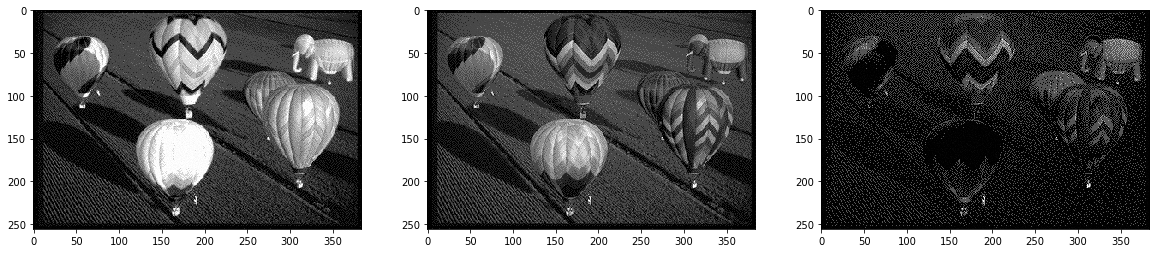

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(r)
ax[1].imshow(g)
ax[2].imshow(b);

In [19]:
# by = ((b - np.min(r,g)) / np.max(np.max(r,g),b)) # (B-Y)
# rg = ((r - g) /np.max(np.max(r,g),b)); # (R-G)

In [20]:
by = np.divide((b - np.minimum(r,g)), np.maximum(np.maximum(r,g),b)) # (B-Y)
by_no_nan = np.nan_to_num(by)

/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [21]:
rg = ((r - g) /np.maximum(np.maximum(r,g),b)); # (R-G)
rg_no_nan = np.nan_to_num(rg)

/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


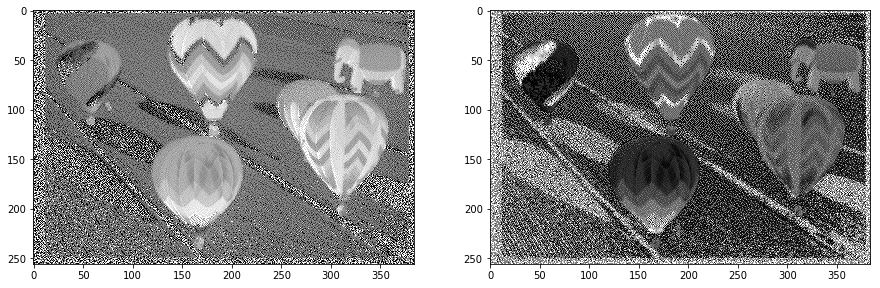

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(rg)
ax[1].imshow(by);

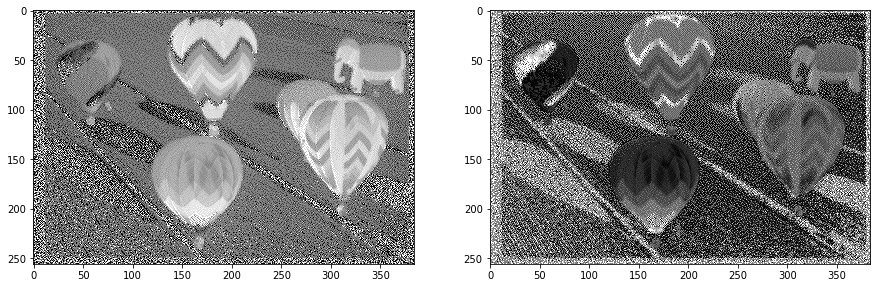

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(rg_no_nan)
ax[1].imshow(by_no_nan);

### Orientation filter

In [24]:
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

In [25]:
theta = 1
theta = theta / 4. * np.pi
sigma = 4
frequency = 0.25

kernel = np.real(gabor_kernel(frequency, theta=theta,
                              sigma_x=sigma, sigma_y=sigma))

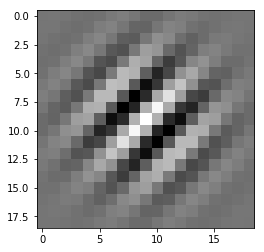

In [26]:
plt.imshow(kernel);

In [27]:
np.shape(kernel)

(19, 19)

In [28]:
from scipy import ndimage as nd

In [29]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = nd.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

In [41]:
from skimage import data
brick = img_as_float(data.load('brick.png'))
np.shape(brick)

(512, 512)

In [36]:
orientation = nd.convolve(img_list[1][:,:,0], kernel)

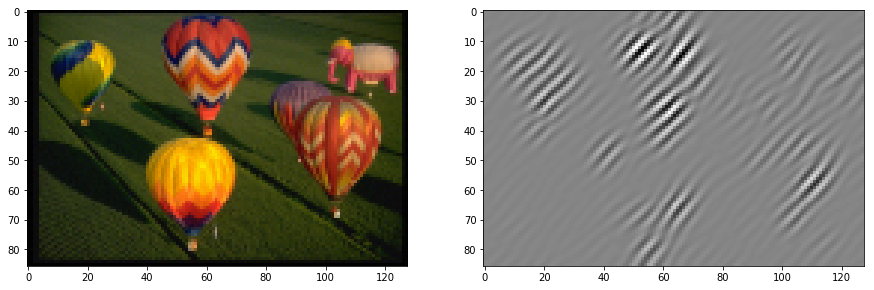

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(img_list[1])
ax[1].imshow(orientation);

### Color Bias

In [32]:
from skimage.color import rgb2hsv

In [33]:
img_hsv = rgb2hsv(img)

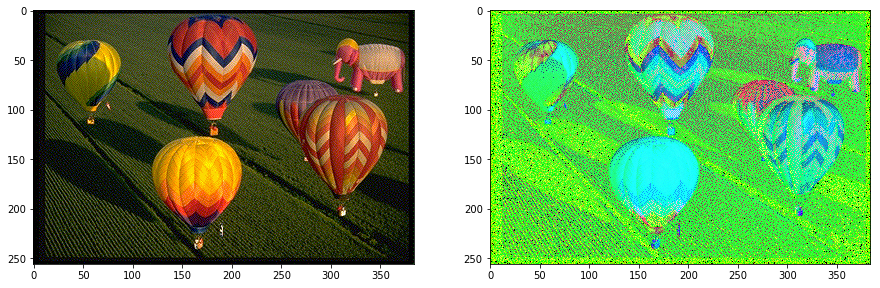

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(img)
ax[1].imshow(img_hsv);

----

## apply center surround